# Cross-Validation and Model Selection

#### 🎯 Learning Goals

1. Understand the concepts of **Cross-Validation**.
2. Learn how to perform **Model Selection** using `sklearn`.

In [1]:
# Load our libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import dsf_helpers as dsfh

# Use a nicer style for plots
plt.style.use("seaborn-v0_8-muted")

## Linear Regression with Cross-Validation

To predict crop yields, we'll deploy the `LinearRegression` model from `sklearn`. While we previously saw that higher degrees of polynomials led to overfitting, in this notebook, we will aim to select the optimal polynomial degree for our model using **Cross-Validation**.

Here's why Cross-Validation stands out:
- Employs the entirety of the dataset for both training and validation.
- Offers a more robust performance assessment, reflecting the model's capability to handle unseen data.

In essence, Cross-Validation provides a holistic view, ensuring we select our model using a comprehensive data evaluation instead of picking a model based on our training data's performance.

___

## Cross-Validation

Cross-validation is a resampling procedure employed to evaluate machine learning models on a limited data sample. Its primary purpose is to limit problems like overfitting, giving an insight into how the model will generalize to an independent dataset. It's essentially about leveraging different subsets of your data to train and validate the model, ensuring that it gets the opportunity to train on multiple train-validation splits. This offers multiple benefits, including a more robust model performance and a better understanding of the model's variance and bias.

### Leave-One-Out Cross-Validation (LOOCV)

Leave-One-Out Cross-Validation, often abbreviated as LOOCV, is a particular case of cross-validation where the $K$ (number of data splits) is set to the number of observations in the dataset. In LOOCV, the model is trained on all data points except one, which serves as the test set. This process is iteratively repeated until each data point has had a chance to be the validation set. However, LOOCV can be computationally expensive due to the number of times the model has to be retrained. It is, therefore, mostly practical for smaller datasets.

### K-Fold Cross-Validation

In K-Fold Cross-Validation, the dataset is randomly partitioned into $K$ equal-sized subsets (or folds). Of these, a single fold is retained as the validation set for model validation, while the remaining K-1 folds are used for training. This process is repeated K times, ensuring each fold gets a turn to serve as the validation set. The results from all $K$ validations are then averaged to produce a single estimation. K-Fold Cross-Validation is particularly beneficial when the dataset size is limited, as it ensures that every data point gets to be in both the training and validation sets, providing a more comprehensive view of the model's performance. Typically, values of K$$ like 5 or 10 are chosen, considering the balance between computational cost and the reliability of the performance estimation.


The `scikit-learn` documentation provides a great visual of cross-validation. The visual is shown below for a 5-fold cross-validation, but the intuition is the same for any value of $K$ (also $K=n$ for LOOCV):

![](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

In [2]:
# 🙀 🤯 Creates the orthogonal polynomial features
def poly(X, degree):
    X = np.array(X)
    # Transform X to a column vector if it is a 1D array
    if X.ndim == 1:
        X = X.reshape(-1, 1) 
    # Initial standard polynomial features
    n_samples, n_features = X.shape
    poly_features = np.column_stack([X**i for i in range(degree + 1)])

    # Gram-Schmidt orthogonalization
    ortho_features = np.zeros_like(poly_features)
    for i in range(poly_features.shape[1]):
        vector = poly_features[:, i]
        for j in range(i):
            vector -= (np.dot(poly_features[:, i], ortho_features[:, j]) /
                       np.dot(ortho_features[:, j], ortho_features[:, j])) * ortho_features[:, j]
        ortho_features[:, i] = vector

    # Normalize
    ortho_features = ortho_features / np.linalg.norm(ortho_features, axis=0)

    return ortho_features[:, 1:] # Remove the constant feature

In [3]:
# Begin by loading the data, the US crop yields data
crops = pd.read_csv("data/us_crops.csv")

# Add the polynomial features directly to the DataFrame
max_degree = 50 # The maximum degree of the polynomial features
poly_features = poly(crops["temp"], max_degree)
for i in range(max_degree):
    crops[f"temp_{i+1}"] = poly_features[:, i]

crops.head()

,temp,yield,temp_1,temp_2,temp_3,temp_4,temp_5,temp_6,temp_7,temp_8,...,temp_41,temp_42,temp_43,temp_44,temp_45,temp_46,temp_47,temp_48,temp_49,temp_50
0,16.64,462.771538,0.085452,-0.021123,-0.101684,-0.072432,0.038104,0.093795,0.047821,-0.042499,...,0.025161,0.216434,0.167683,0.118409,0.051547,-0.038898,-0.044638,-0.056025,-0.070843,0.020952
1,11.37,725.362676,-0.075146,-0.053394,0.120347,-0.045242,-0.075265,0.119760,-0.018505,-0.104748,...,-0.190459,0.020283,-0.018843,-0.010922,-0.082032,-0.104128,-0.040415,0.016425,0.136559,0.030220
2,12.52,776.967318,-0.040101,-0.093435,0.085984,0.058579,-0.111639,0.016276,0.116732,-0.057212,...,-0.004887,0.092748,-0.056767,0.057712,0.137440,-0.100182,0.080878,-0.045234,-0.094474,0.085112
3,13.79,718.718013,-0.001399,-0.107112,0.010923,0.111538,-0.021480,-0.102326,0.025938,0.103361,...,0.084447,-0.067930,-0.082051,0.050961,-0.020406,0.249459,-0.152221,-0.042505,-0.121052,-0.015597
4,11.97,533.642120,-0.056861,-0.077564,0.108321,0.011893,-0.111432,0.080290,0.072008,-0.118315,...,-0.094716,-0.041211,0.115475,-0.070184,-0.026193,-0.032059,-0.014656,0.005608,-0.235785,0.133079


In [4]:
# Import the necessary tools from scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [5]:
# Notice that temp_1 is not the same as temp, this is because we have orthogonalized the polynomials
X = crops.drop(columns=["temp", "yield"]) # Keep only the polynomial features
y = crops["yield"] # The yield is the target

# As before, we first split the data into a training and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=25)

In `scikit-learn`, we can implement cross-validation using the `cross_val_score` function from the `model_selection` module. It takes the model, the entire dataset, and the number of folds as input. It returns the validation scores for each fold.

#### ➡️ ✏️ Task 1

Observe the code below, implementing cross-validation for a linear regression model with 5 folds. Why did we not use `.fit(X_train_subset, y_train)` to train the model?

In [6]:
# Create the 5-fold cross-validation object
cv = KFold(n_splits=5, shuffle=True, random_state=72)

# Initialize the list of scores (MSEs, one for each degree of Polynomial)
scores = []

# Loop over the degrees of the polynomial
for degree in range(1, max_degree+1):
    # Subset the training data to keep only the polynomial features up to the current degree
    X_train_subset = X_train.loc[:, X_train.columns[:degree]]

    # Initialize the model
    model = LinearRegression()

    # Compute the cross-validation score using the current degree of the polynomial
    # and the mean squared error as the scoring function
    cv_score = cross_val_score(model, X_train_subset, y_train, 
                               cv=cv, scoring="neg_mean_squared_error")
    
    # Append the mean of the cross-validation scores to the list of scores
    scores.append(-np.mean(cv_score)) # Notice the minus sign, because the MSE is negative

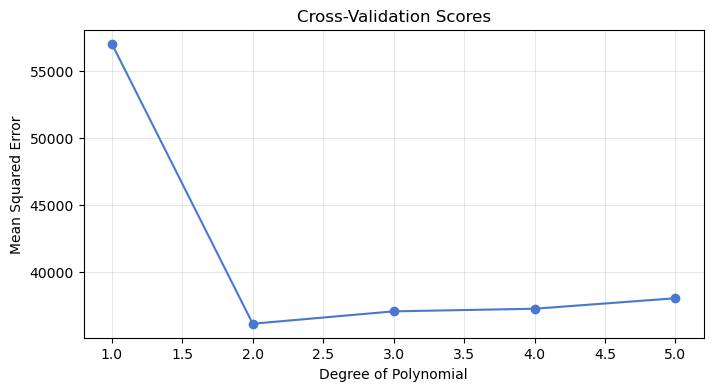

In [7]:
# Plot the scores as a function of the degree of the polynomial
fig, ax = plt.subplots(figsize=(8, 4))

plot_degree = 5 # Degree up to which we plot the scores (the rest has too high MSE)

ax.plot(range(1, plot_degree+1), scores[:plot_degree], marker="o")
ax.set_xlabel("Degree of Polynomial")
ax.set_ylabel("Mean Squared Error")
ax.set_title("Cross-Validation Scores")
ax.grid(alpha=.3)

In [8]:
print(f"Best degree of polynomial: {np.argmin(scores)+1}")

Best degree of polynomial: 2


#### ➡️ ✏️ Task 2

Repeat the above task but use $K=10$ and $K=n$ (LOOCV) folds. Do you notice any difference in the validation scores? What about in the speed of execution?

In [9]:
# ➡️ ✏️ Your code here

Best degree of polynomial: 2


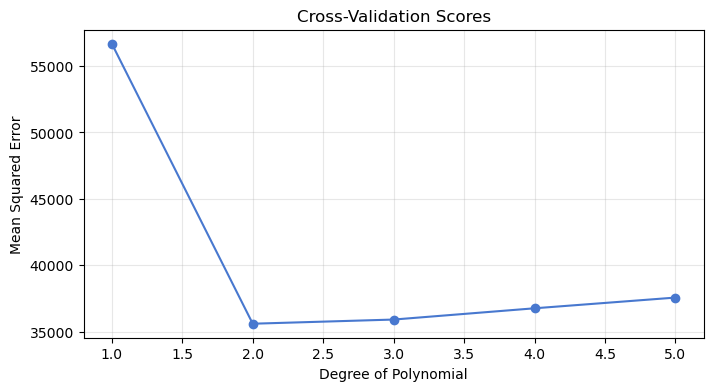

In [10]:
# Create the 5-fold cross-validation object
cv = KFold(n_splits=len(y_train), shuffle=True, random_state=72)

# Initialize the list of scores (MSEs, one for each degree of Polynomial)
scores = []

# Loop over the degrees of the polynomial
for degree in range(1, max_degree+1):
    # Subset the training data to keep only the polynomial features up to the current degree
    X_train_subset = X_train.loc[:, X_train.columns[:degree]]

    # Initialize the model
    model = LinearRegression()

    # Compute the cross-validation score using the current degree of the polynomial
    # and the mean squared error as the scoring function
    cv_score = cross_val_score(model, X_train_subset, y_train, 
                               cv=cv, scoring="neg_mean_squared_error")
    
    # Append the mean of the cross-validation scores to the list of scores
    scores.append(-np.mean(cv_score)) # Notice the minus sign, because the MSE is negative

# Plot the scores as a function of the degree of the polynomial
fig, ax = plt.subplots(figsize=(8, 4))

plot_degree = 5 # Degree up to which we plot the scores (the rest has too high MSE)

ax.plot(range(1, plot_degree+1), scores[:plot_degree], marker="o")
ax.set_xlabel("Degree of Polynomial")
ax.set_ylabel("Mean Squared Error")
ax.set_title("Cross-Validation Scores")
ax.grid(alpha=.3)

print(f"Best degree of polynomial: {np.argmin(scores)+1}")

Best degree of polynomial: 2


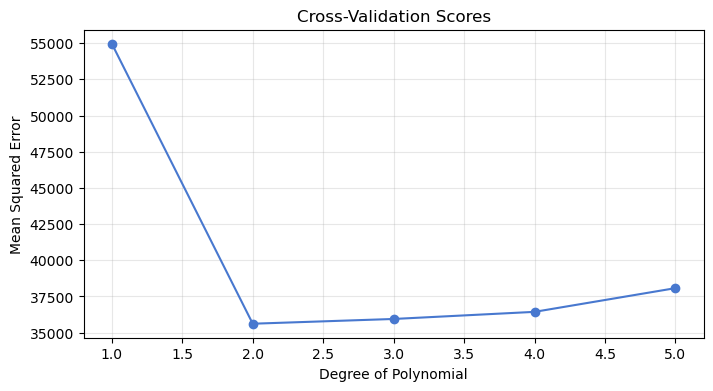

In [11]:
# Create the 5-fold cross-validation object
cv = KFold(n_splits=10, shuffle=True, random_state=72)

# Initialize the list of scores (MSEs, one for each degree of Polynomial)
scores = []

# Loop over the degrees of the polynomial
for degree in range(1, max_degree+1):
    # Subset the training data to keep only the polynomial features up to the current degree
    X_train_subset = X_train.loc[:, X_train.columns[:degree]]

    # Initialize the model
    model = LinearRegression()

    # Compute the cross-validation score using the current degree of the polynomial
    # and the mean squared error as the scoring function
    cv_score = cross_val_score(model, X_train_subset, y_train, 
                               cv=cv, scoring="neg_mean_squared_error")
    
    # Append the mean of the cross-validation scores to the list of scores
    scores.append(-np.mean(cv_score)) # Notice the minus sign, because the MSE is negative

# Plot the scores as a function of the degree of the polynomial
fig, ax = plt.subplots(figsize=(8, 4))

plot_degree = 5 # Degree up to which we plot the scores (the rest has too high MSE)

ax.plot(range(1, plot_degree+1), scores[:plot_degree], marker="o")
ax.set_xlabel("Degree of Polynomial")
ax.set_ylabel("Mean Squared Error")
ax.set_title("Cross-Validation Scores")
ax.grid(alpha=.3)

print(f"Best degree of polynomial: {np.argmin(scores)+1}")

___

## Diving Deeper: Cross-Validated Lasso and Ridge Regression

The bike rental dataset we've been analyzing offers a rich set of variables, and till now, we've merely skimmed its surface by focusing on a select subset: `temp`, `windspeed`, and `hum`.

### Why Expand Our Feature Set?
- **Information Utilization**: The unused columns might harbor critical insights and patterns that can significantly impact the accuracy of our predictions.
- **Complex Relationships**: While we started with basic features, more advanced features can capture intricate relationships, nonlinearities, and interactions that we might have missed.

### The Role of Lasso and Ridge Regression:
Regularization techniques, like Lasso and Ridge regression, shine when dealing with high-dimensional datasets:
- **Feature Selection (Lasso)**: Lasso regression performs automatic feature selection. This means that by including more features, Lasso can zero out the less relevant ones, enabling us to focus on the most impactful predictors.
- **Overfitting Prevention (Ridge)**: Ridge regression helps combat overfitting when we use a vast number of predictors, ensuring our model remains generalizable.

### Cross-Validation: The Cornerstone of Reliable Model Assessment
- By integrating cross-validation, we ensure a thorough evaluation of our model's performance, mitigating the risk of coincidental high accuracies on a particular data split.
- Cross-validation gives us confidence in the stability and reliability of our model by testing it on various data partitions.

With the tools and techniques at our disposal, our objective is clear: harness the full potential of the dataset, employ advanced regularization techniques, and meticulously evaluate our model using cross-validation. The aim? Achieving a model performance that substantially outperforms our initial models, without spending hours on feature engineering. 


In [12]:
rentals = pd.read_csv("data/bike_rental.csv")
rentals.head()

,season,y2012,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,...,weekday0,weekday1,weekday2,weekday3,weekday4,weekday5,weekday6,weathersit1,weathersit2,weathersit34
0,1,0,1,0,0,6,0,1,0.24,0.2879,...,0,0,0,0,0,0,1,1,0,0
1,1,0,1,1,0,6,0,1,0.22,0.2727,...,0,0,0,0,0,0,1,1,0,0
2,1,0,1,2,0,6,0,1,0.22,0.2727,...,0,0,0,0,0,0,1,1,0,0
3,1,0,1,3,0,6,0,1,0.24,0.2879,...,0,0,0,0,0,0,1,1,0,0
4,1,0,1,4,0,6,0,1,0.24,0.2879,...,0,0,0,0,0,0,1,1,0,0


In [13]:
# Show the summary statistics of the rentals data
rentals.describe()

,season,y2012,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,...,weekday0,weekday1,weekday2,weekday3,weekday4,weekday5,weekday6,weathersit1,weathersit2,weathersit34
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,...,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,...,0.143967,0.142643,0.141147,0.142413,0.142183,0.143104,0.144542,0.656712,0.261465,0.081823
std,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,...,0.351066,0.349719,0.348184,0.349484,0.349248,0.350189,0.351649,0.474820,0.439445,0.274103
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Observations on Variables

From our data statistics above:

1. **Scaling Discrepancies**:
    - Some variables are **not**:
        1. &hellip; within the range $[0, 1]$.
        2. &hellip; normalized with a mean of $0$ and a standard deviation of $1$.
    
2. **Categorical Variables**:
    - Some are categorical and do not imply order (e.g., `season`, the value $2$ is not *twice as much* as the value $1$).

These nuances can affect the behavior of linear models, especially when using regularization.

### The Importance of Normalization for Regularization

**Regularization** aims to prevent overfitting by penalizing large coefficients. It's crucial to remember how it works:
    
Suppose you're modeling a person's weight using their height. Two models are the same but one uses heigh in meters and the other in centimeters. Then the coefficients will differ substantially.`

**Note**: The coefficient for height in centimeters would be much smaller than for height in meters (by a factor of $100$) – even though they represent the same height! E.g., it is not hard to show that 

$$\begin{align*}
\hat{f}(\mathbf{x}) &= \hat{\beta}_0 + \hat{\beta}_1 \cdot \text{height\_in\_meters}\\
&= \hat{\beta}_0 + \hat{\beta}_1 \cdot \frac{\text{height\_in\_centimeters}}{100}\\
&= \hat{\beta}_0 + \frac{\hat{\beta}_1}{100} \cdot \text{height\_in\_centimeters}
\end{align*}$$

If we use regularization without normalization, the model might heavily penalize the `height_in_meters` variable just because of its scale, leading to a misleading model.

Using normalization, i.e., either scaling to $[0, 1]$ or standardizing to mean $0$ and standard deviation $1$, we rescale the two variables such that they are equal. Thus, regularization will treat them equally. **Don't forget to normalize your data!**

### Categorical Variables and Dummy Variables
Consider the season variable. If we use numbers like 1 for winter and 3 for summer, a linear model built as

$$\hat{f}(\mathbf{x}) = \hat{\beta}_0 + \hat{\beta}_1 \cdot \text{season}$$

will implicitly model the seasons using the same coefficient $\hat{\beta}_1$. Suppose that winter has a negative impact on bike rentals, while summer has a positive one. We would expect $\hat{\beta}_1$ to be negative. However, since summer is represented by the number 3, $\hat{\beta}_1$ will be three times larger than if we had used 1 for summer. This is not what we want!


Instead, we use dummy variables (or one-hot encoding):

+ `is_summer`: 1 for summer, 0 otherwise
+ `is_winter`: 1 for winter, 0 otherwise

This way, each season gets its own coefficient, and there's no implied order or magnitude difference between them.

$$\hat{f}(\mathbf{x}) = \hat{\beta}_0 + \hat{\beta}_1 \cdot \text{is\_winter} + \hat{\beta}_2 \cdot \text{is\_summer}$$
Remember: Data preprocessing can be as crucial as model selection!




In [14]:
# To create the one-hot encoded features, we may use the get_dummies function from pandas
pd.get_dummies(rentals, columns=["season", "weekday"])

,y2012,mnth,hr,holiday,workingday,weathersit,temp,atemp,hum,windspeed,...,season_2,season_3,season_4,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,1,0,0,0,1,0.24,0.2879,0.81,0.0000,...,False,False,False,False,False,False,False,False,False,True
1,0,1,1,0,0,1,0.22,0.2727,0.80,0.0000,...,False,False,False,False,False,False,False,False,False,True
2,0,1,2,0,0,1,0.22,0.2727,0.80,0.0000,...,False,False,False,False,False,False,False,False,False,True
3,0,1,3,0,0,1,0.24,0.2879,0.75,0.0000,...,False,False,False,False,False,False,False,False,False,True
4,0,1,4,0,0,1,0.24,0.2879,0.75,0.0000,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1,12,19,0,1,2,0.26,0.2576,0.60,0.1642,...,False,False,False,False,True,False,False,False,False,False
17375,1,12,20,0,1,2,0.26,0.2576,0.60,0.1642,...,False,False,False,False,True,False,False,False,False,False
17376,1,12,21,0,1,1,0.26,0.2576,0.60,0.1642,...,False,False,False,False,True,False,False,False,False,False
17377,1,12,22,0,1,1,0.26,0.2727,0.56,0.1343,...,False,False,False,False,True,False,False,False,False,False


In [15]:
# In our case, this has already been done before, notice e.g., the columns
# spring, summer, fall, winter, and the columns weekday0, weekday1, etc.
# Thus we can simply remove the original columns
rentals.drop(columns=["season", "weekday", "mnth", "hr", "weathersit"], 
            inplace=True)

In [16]:
rentals.describe()

,y2012,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,weekday0,weekday1,weekday2,weekday3,weekday4,weekday5,weekday6,weathersit1,weathersit2,weathersit34
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,...,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,0.502561,0.028770,0.682721,0.496987,0.475775,0.627229,0.190098,189.463088,0.244088,0.253697,...,0.143967,0.142643,0.141147,0.142413,0.142183,0.143104,0.144542,0.656712,0.261465,0.081823
std,0.500008,0.167165,0.465431,0.192556,0.171850,0.192930,0.122340,181.387599,0.429557,0.435139,...,0.351066,0.349719,0.348184,0.349484,0.349248,0.350189,0.351649,0.474820,0.439445,0.274103
min,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.340000,0.333300,0.480000,0.104500,40.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.500000,0.484800,0.630000,0.194000,142.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.660000,0.621200,0.780000,0.253700,281.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.850700,977.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
# First, separate the data into features and target
X = rentals.drop(columns="cnt") # Keep all possible features
y = rentals["cnt"]

In [18]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=72)

#### ➡️ ✏️ Task 3

Using `sklearn`'s `LinearRegression`, build a simple model that uses only the features `temp`, `windspeed`, and `hum` to predict the `cnt` column. Fit the model on the train set, we will use the test set later to compare the performance of this model with the model we will build using cross-validation.

In [19]:
# ➡️ ✏️ Create a linear regression model and fit it on the training data
# using only temp, windspeed, and hum as features
linreg = None # Use the variable name linreg for your model

In [20]:
linreg = LinearRegression().fit(X_train[["temp", "windspeed", "hum"]], y_train)

In [21]:
# Print the MSE of the linear regression on the training and test data
if linreg is not None:
    mse_train = mean_squared_error(y_train, linreg.predict(X_train[["temp", "windspeed", "hum"]]))
    mse_test = mean_squared_error(y_test, linreg.predict(X_test[["temp", "windspeed", "hum"]]))
    print(f"Training MSE: {mse_train:.2f}")
    print(f"Testing MSE : {mse_test:.2f}")

Training MSE: 24822.36
Testing MSE : 24055.25


In `scikit-learn`, the Lasso and Ridge models come directly with a cross-validation variant that performs cross-validation internally. The `LassoCV` and `RidgeCV` classes can be imported from the `linear_model` module. They take the same parameters as their non-cross-validated counterparts, but they also take an additional parameter `cv` that specifies the type of cross-validation to use. The `cv` parameter can be set to an integer, in which case the folds are created using `KFold` with the specified number of folds. Alternatively, it can be set to a cross-validation generator.

This makes CV with Lasso and Ridge very easy to implement. We can simply pass the `LassoCV` and `RidgeCV` classes the entire dataset, and they will perform cross-validation internally. The `LassoCV` and `RidgeCV` classes also have a `cv_values_` attribute that contains the validation scores for each fold.

In [22]:
# Import the CV version of the Lasso and Ridge regression models
from sklearn.linear_model import LassoCV, RidgeCV

In [23]:
# Cross-validation setup
cv = KFold(n_splits=5, shuffle=True, random_state=72) # 5-fold CV

# Choosing which alphas we want to try out in the CV (optional)
alphas = np.logspace(-3, 3, 100) # Try out 100 alphas between 10^-3 and 10^3

In [24]:
lasso = LassoCV(alphas=alphas, cv=cv)
lasso.fit(X_train, y_train)

LassoCV(alphas=array([1.00000000e-03, 1.14975700e-03, 1.32194115e-03, 1.51991108e-03,
       1.74752840e-03, 2.00923300e-03, 2.31012970e-03, 2.65608778e-03,
       3.05385551e-03, 3.51119173e-03, 4.03701726e-03, 4.64158883e-03,
       5.33669923e-03, 6.13590727e-03, 7.05480231e-03, 8.11130831e-03,
       9.32603347e-03, 1.07226722e-02, 1.23284674e-02, 1.41747416e-02,
       1.62975083e-02, 1.87381742e-0...
       7.05480231e+01, 8.11130831e+01, 9.32603347e+01, 1.07226722e+02,
       1.23284674e+02, 1.41747416e+02, 1.62975083e+02, 1.87381742e+02,
       2.15443469e+02, 2.47707636e+02, 2.84803587e+02, 3.27454916e+02,
       3.76493581e+02, 4.32876128e+02, 4.97702356e+02, 5.72236766e+02,
       6.57933225e+02, 7.56463328e+02, 8.69749003e+02, 1.00000000e+03]),
        cv=KFold(n_splits=5, random_state=72, shuffle=True))

But what are the values of `alpha` (i.e., $\lambda$) that were used in the cross-validation tuning process? The `LassoCV` and `RidgeCV` classes have an `alpha_` attribute that contains the optimal value of `alpha` that was found during cross-validation.

Best regularization parameter: 0.02


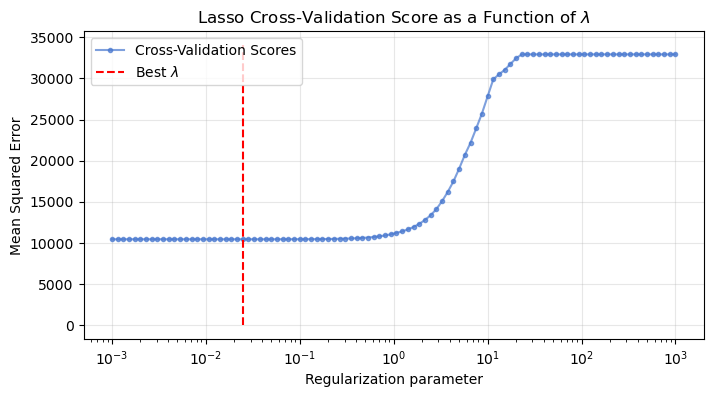

In [25]:
# Set up the figure
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the CV MSE for each value of the regularization parameter that was tried
ax.plot(lasso.alphas_, lasso.mse_path_.mean(axis=1), marker="o", markersize=3,
        alpha=0.7, label="Cross-Validation Scores")
# Plot the final chosen regularization parameter
ax.vlines(lasso.alpha_, 0, ax.get_ylim()[1], linestyle="--", color="red", label="Best $\lambda$")

# Aesthetics
ax.set_xscale("log")
ax.set_xlabel("Regularization parameter")
ax.set_ylabel("Mean Squared Error")
ax.set_title("Lasso Cross-Validation Score as a Function of $\lambda$")
ax.grid(alpha=0.3)
ax.legend()

print(f"Best regularization parameter: {lasso.alpha_:.2f}")


In [26]:
ridge = RidgeCV(alphas=alphas, cv=cv)
ridge.fit(X_train, y_train)
print(f"Best regularization parameter: {ridge.alpha_:.2f}")

Best regularization parameter: 2.85


#### ➡️ ✏️ Task 4 (optional & difficult)

**Note**: unfortunately, with `RidgeCV`, it is not as easy to plot the values of $\lambda$ and the matching cross-validation scores. You could, however, do it quite easily if you were simply using the `Ridge` object and performing cross-validation yourself, like we did for the polynomial regression above. Go ahead and try it out if you feel up to the task!

In [27]:
# ➡️ ✏️ Your code here

Best regularization parameter: 0.02


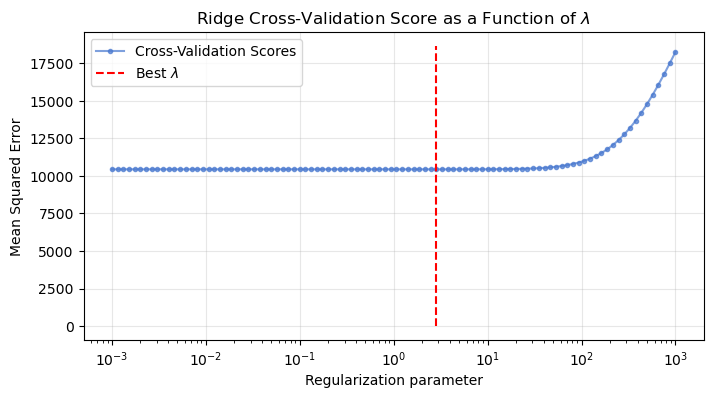

In [28]:
from sklearn.linear_model import Ridge

# Create a list of MSEs for each value of alpha
mse_scores = []

# Loop over the alphas
for alpha in alphas:
    # Initialize the model
    ridge = Ridge(alpha=alpha)

    # Fit the model using CV
    score = cross_val_score(ridge, X_train, y_train, 
                            cv=cv, scoring="neg_mean_squared_error")
    
    # Append the mean of the cross-validation scores to the list of scores
    mse_scores.append(-np.mean(score))


# Plotting
# Set up the figure
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the CV MSE for each value of the regularization parameter that was tried
ax.plot(alphas, mse_scores, marker="o", markersize=3,
        alpha=0.7, label="Cross-Validation Scores")
# Plot the final chosen regularization parameter
ax.vlines(alphas[np.argmin(mse_scores)], 0, ax.get_ylim()[1], linestyle="--", 
          color="red", label="Best $\lambda$")

# Aesthetics
ax.set_xscale("log")
ax.set_xlabel("Regularization parameter")
ax.set_ylabel("Mean Squared Error")
ax.set_title("Ridge Cross-Validation Score as a Function of $\lambda$")
ax.grid(alpha=0.3)
ax.legend()

print(f"Best regularization parameter: {lasso.alpha_:.2f}")


#### ➡️ ✏️ Task 5

Write your own code to compare the predictions of the three models we have built so far on the train and test sets. Which model performs the best?

In [31]:
ridge = RidgeCV(alphas=alphas, cv=cv)
ridge.fit(X_train, y_train)
print(f"Best regularization parameter: {ridge.alpha_:.2f}")

Best regularization parameter: 2.85


Linear Regression Training MSE: 24822.36
Linear Regression Testing MSE : 24055.25
Lasso Training MSE: 10347.85
Lasso Testing MSE : 10253.94
Ridge Training MSE: 10347.56
Ridge Testing MSE : 10256.10


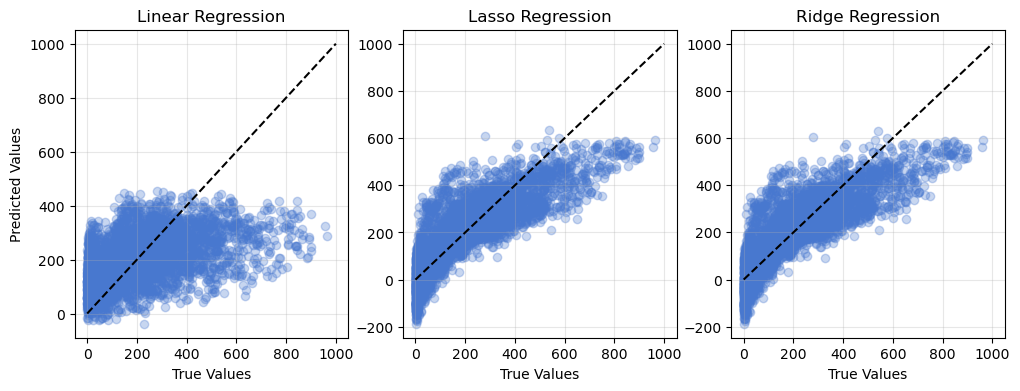

In [32]:
linreg_mse_train = mean_squared_error(y_train, linreg.predict(X_train[["temp", "windspeed", "hum"]]))
linreg_mse_test = mean_squared_error(y_test, linreg.predict(X_test[["temp", "windspeed", "hum"]]))
print(f"Linear Regression Training MSE: {linreg_mse_train:.2f}")
print(f"Linear Regression Testing MSE : {linreg_mse_test:.2f}")

lasso_mse_train = mean_squared_error(y_train, lasso.predict(X_train))
lasso_mse_test = mean_squared_error(y_test, lasso.predict(X_test))
print(f"Lasso Training MSE: {lasso_mse_train:.2f}")
print(f"Lasso Testing MSE : {lasso_mse_test:.2f}")

ridge_mse_train = mean_squared_error(y_train, ridge.predict(X_train))
ridge_mse_test = mean_squared_error(y_test, ridge.predict(X_test))
print(f"Ridge Training MSE: {ridge_mse_train:.2f}")
print(f"Ridge Testing MSE : {ridge_mse_test:.2f}")


# Plot true values vs. predicted values on the test set for all three models
fig, axs= plt.subplots(1, 3, figsize=(12, 4))


axs[0].scatter(y_test, linreg.predict(X_test[["temp", "windspeed", "hum"]]), alpha=.3)
axs[0].set_title("Linear Regression")

axs[1].scatter(y_test, lasso.predict(X_test), alpha=.3)
axs[1].set_title("Lasso Regression")

axs[2].scatter(y_test, ridge.predict(X_test), alpha=.3)
axs[2].set_title("Ridge Regression")

axs[0].set_ylabel("Predicted Values")

# Common aesthetics
for ax in axs:
    ax.plot([0, 1000], [0, 1000], "--", color="black")
    ax.set_xlabel("True Values")
    ax.grid(alpha=.3)